In [101]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score

In [68]:
# Load the dataset 
data = pd.read_csv("../dataset/original/train.csv", sep=",", encoding='utf-8', na_values=['_', '_______', '#F%$D@*&8', '!@9#%8', 'nan'])

/var/folders/cf/h6s9q7h52p52lmfbv8wmh20h0000gn/T/ipykernel_64781/219089285.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../dataset/original/train.csv", sep=",", encoding='utf-8', na_values=['_', '_______', '#F%$D@*&8', '!@9#%8', 'nan'])


In [69]:
# Converting to Numeric representation
features_to_be_num = ['Age', 'Num_of_Loan']
for feature in features_to_be_num:
  data[feature] = data[feature].str.extract('(\d+)').astype(int) # Modify df

features_to_be_num = ['Outstanding_Debt','Annual_Income','Amount_invested_monthly','Monthly_Balance']
for feature in features_to_be_num:
  data[feature] = data[feature].str.extract(r'(\d+\.\d+)').astype(float)

data['Num_of_Delayed_Payment'] = data['Num_of_Delayed_Payment'].str.extract('(\d+)').astype(float) # Modify df

# get customer id for nan values in Name Column
Customer_IDs = data[data['Name'].isnull()]['Customer_ID'].values

#### Changed Credit Limit
data['Changed_Credit_Limit'] = data.groupby('Customer_ID')['Changed_Credit_Limit'].transform(lambda x: x.interpolate(method='index', limit_direction='both')) # Modify df

#### Num Credit Inquiries
data['Num_Credit_Inquiries'] = data.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x) # Modify df

#### Credit Mix
# Create a dictionary to map Customer_ID to non-null Credit_Mix values
Credit_Mix_mapping = data.dropna(subset=['Credit_Mix']).set_index('Customer_ID')['Credit_Mix'].to_dict()

# Fill missing Credit_Mix values based on Customer_ID
data['Credit_Mix'] = data.apply(lambda row: Credit_Mix_mapping.get(row['Customer_ID'], row['Credit_Mix']), axis=1) # Modify df

#### Num of Delayed Payment
data['Num_of_Delayed_Payment'] = data.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x) # Modify df 

In [70]:
def Month_Converter(x):
    if pd.notnull(x):
        num1 = int(x.split(' ')[0])
        num2 = int(x.split(' ')[3])
      
        return (num1*12)+num2
    else:
        return x

In [71]:
data.Month = pd.to_datetime(data.Month,format="%B").dt.month
data.Month = data.Month.astype(np.int64)

In [72]:
#### Monthly Inhand Salary
# Create a dictionary to map Customer_ID to non-null Monthly_Inhand_Salary values
Monthly_Inhand_Salary_mapping = data.dropna(subset=['Monthly_Inhand_Salary']).set_index('Customer_ID')['Monthly_Inhand_Salary'].to_dict()

# Fill missing Monthly_Inhand_Salary values based on Customer_ID
data['Monthly_Inhand_Salary'] = data.apply(lambda row: Monthly_Inhand_Salary_mapping.get(row['Customer_ID'], row['Monthly_Inhand_Salary']), axis=1) # Modify df

#### Amount_invested_monthly
data['Amount_invested_monthly'] = data.groupby('Customer_ID')['Amount_invested_monthly'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x) # Modify df

#### Payment Behaviour
# Define a custom function to calculate mode with handling for NaN values
def custom_mode(series):
  mode_values = series.dropna().mode()
  if mode_values.empty:
    return np.nan
  return mode_values.iloc[0]

# Calculate the mode payment behavior for each customer
customer_mode_payment = data.groupby('Customer_ID')['Payment_Behaviour'].transform(custom_mode)

# Fill missing values with the corresponding customer's mode payment behavior
data['Payment_Behaviour'] = data['Payment_Behaviour'].fillna(customer_mode_payment) # Modify df

#### Monthly Balance
data['Monthly_Balance'] = data.groupby('Customer_ID')['Monthly_Balance'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x) # Modify df

#### Credit History Age
data.Credit_History_Age = data.Credit_History_Age.apply(lambda x: Month_Converter(x)).astype(np.float64) # Modify df
data['Credit_History_Age'] = data.groupby('Customer_ID')['Credit_History_Age'].transform(
    lambda x: x.interpolate(method='index', limit_direction='both') if x.count() > 1 else x) # Modify df 

# Encoding

In [84]:
df = data.copy() 
df.columns
df.ID = df.ID.apply(lambda x: int(x,16)).astype(np.int64)  # Modify df
df.Customer_ID = df.Customer_ID.apply(lambda x: int(x[4:],16)).astype(np.int64)  # Modify df 

In [85]:
df['Credit_Score'] = LabelEncoder().fit_transform(df['Credit_Score'])

In [86]:
columns = ['Payment_of_Min_Amount','Payment_Behaviour','Credit_Mix']
for item in columns:
    df[item] = ce.LeaveOneOutEncoder().fit_transform(df[item],df['Credit_Score'])

In [87]:
columns2 =['Annual_Income','Age','Num_Credit_Card','Interest_Rate','Delay_from_due_date','Num_of_Delayed_Payment','Monthly_Balance',
                           'Num_Credit_Inquiries','Changed_Credit_Limit','Credit_History_Age',
                           'Outstanding_Debt','Total_EMI_per_month']
for item in columns2:
    mean_encoding = df.groupby([item])['Credit_Score'].mean()
    df[item] = df[item].map(mean_encoding)

In [88]:
columns =['ID', 'Customer_ID', 'SSN', 'Name', 'Occupation', 'Annual_Income', 'Type_of_Loan', 'Num_of_Loan', 'Outstanding_Debt']

df.drop(columns, axis=1, inplace=True)
df.dropna(inplace=True)

In [89]:
X = df.drop('Credit_Score', axis=1)
y = df.Credit_Score

smote = SMOTE()
X, y = smote.fit_resample(X,y)

# Modeling

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,shuffle=True,random_state=42)

In [113]:
scaler = StandardScaler()
features = X_train.columns
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train,columns=features)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test,columns=features)

In [112]:
def train_and_evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    acc = accuracy_score(y_test,y_pred)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    precision = precision_score(y_test,y_pred,average='micro')
    recall = recall_score(y_test,y_pred,average='micro')
    f1 = f1_score(y_test,y_pred,average='micro')
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10584
           1       1.00      1.00      1.00     10363
           2       1.00      1.00      1.00     10374

    accuracy                           1.00     31321
   macro avg       1.00      1.00      1.00     31321
weighted avg       1.00      1.00      1.00     31321

Train Accuracy: 0.9993694225826535
Test Accuracy: 0.9996168704702915


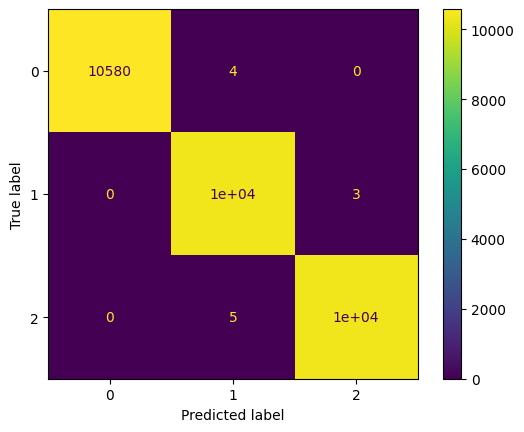

In [114]:
train_and_evaluate_model(LogisticRegression())